In [36]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adtk.detector import ThresholdAD
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

!pip install prophet


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 949.6 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 KB 1.7 MB/s eta 0:00:000:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 KB 910.8 kB/s eta 0:00:0031m4.0 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 1.8 MB/s eta 0:00:00m eta 0:00:010:01:01


In [25]:
#load data and pre-process
df = pd.read_csv('~/Desktop/myProjects/Machine-Learning-and-Python-Projects/Hackathon/gcp_billing_data_20240816 - gcp_billing_data_20240816(in).csv')
df['usage_end_time'] = pd.to_datetime(df['usage_end_time'], format='%m/%d/%Y %H:%M')

#basic plot over time range
df.set_index('usage_end_time', inplace=True)

#get the unique service types
unique_service_types = df['service_type'].unique()

print(f"Unique Service Types: \n{unique_service_types}\n ")
# print(unique_service_types)

#Filter and analyse the unique service types
# df_specific_service = df[df['service_type'] == 'Compute Engine']

# print(df_specific_service.head())


Unique Service Types: 
['Compute Engine' 'Networking' 'Cloud Logging' 'Kubernetes Engine'
 'Cloud Storage' 'BigQuery' 'Vertex AI' 'Cloud Monitoring' 'Cloud SQL'
 'Cloud DNS' 'Cloud Pub/Sub' 'Artifact Registry' 'Cloud Functions'
 'Cloud Build' 'BigQuery Reservation API' 'Deep Learning VM'
 'Cloud Dataflow' 'Dataplex']
 


/tmp/ipykernel_567997/3188633125.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_specific_service.loc[:, 'anomaly'] = model.fit_predict(X)


    usage_end_time       cost  usage_amount    service_type        region  \
0       2023-12-07   3.581648  1.352913e+16  Compute Engine  europe-west1   
4       2023-12-11   6.075154  2.300728e+16  Compute Engine  europe-west1   
6       2023-12-13   8.073586  6.825806e+16  Compute Engine  europe-west1   
36      2024-01-12  12.516894  9.424170e+16  Compute Engine  europe-west1   
63      2024-02-08  17.283384  1.089160e+17  Compute Engine  europe-west1   
250     2024-08-13  49.397205  1.777950e+17  Compute Engine  europe-west1   

       usage_unit  anomaly  
0         seconds       -1  
4    byte-seconds       -1  
6    byte-seconds       -1  
36          bytes       -1  
63          bytes       -1  
250         bytes       -1  


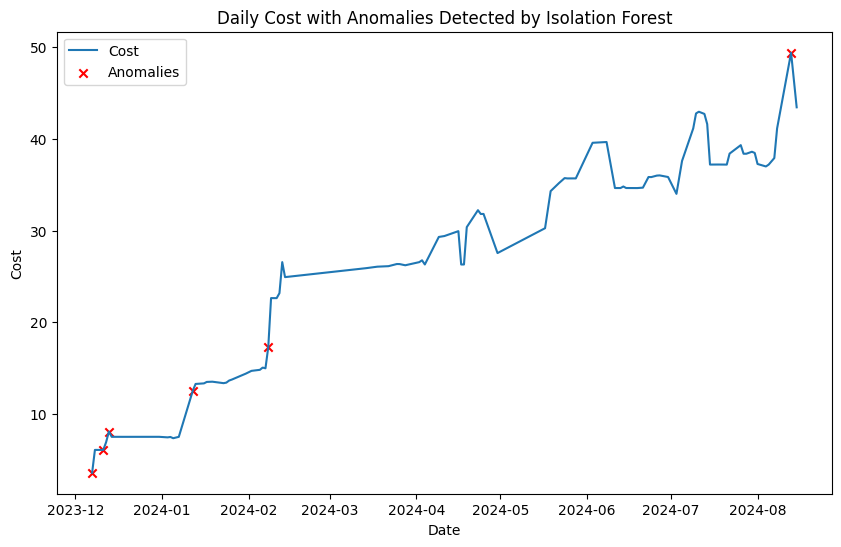

In [103]:
#Anomaly detection - daily - #Filter and analyse the unique service types

# print(df_specific_service.head())

df_daily = df.resample('D').agg({
    'cost': 'sum',            # Sum the cost over each week
    'usage_amount': 'sum',    # Sum the usage amount over each week
    'service_type': 'first',  # Choose the first service type (or use another method if needed)
    'region': 'first',        # Choose the first region (or use another method if needed)
    'usage_unit': 'first'     # Choose the first usage unit (or use another method if needed)
}).reset_index()

#choose for the service
df_daily_specific_service = df_daily[df_daily['service_type'] == 'Compute Engine']

# Assuming df_daily is your daily resampled data and df_daily_specific_service is filtered for 'Compute Engine'
X = df_daily_specific_service[['cost']]

# Initialize the Isolation Forest model
model = IsolationForest(contamination=0.05, random_state=42)

# Fit the model and predict anomalies
# df_daily_specific_service.loc[:, 'anomaly'] = model.fit_predict(X)
df_daily_specific_service.loc[:, 'anomaly'] = model.fit_predict(X)

# Anomalies are labeled as -1, normal points are labeled as 1
anomalies = df_daily_specific_service[df_daily_specific_service['anomaly'] == -1]

# Display the anomalies
print(anomalies)

# Plotting the anomalies
plt.figure(figsize=(10,6))
plt.plot(df_daily_specific_service['usage_end_time'], df_daily_specific_service['cost'], label='Cost')
plt.scatter(anomalies['usage_end_time'], anomalies['cost'], color='red', label='Anomalies', marker='x')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.title('Daily Cost with Anomalies Detected by Isolation Forest')
plt.legend()
plt.show()





    usage_end_time       cost  usage_amount       service_type        region  \
0       2023-12-07   3.581648  1.352913e+16     Compute Engine  europe-west1   
4       2023-12-11   6.075154  2.300728e+16     Compute Engine  europe-west1   
5       2023-12-12   6.913358  4.363868e+16     Compute Engine  europe-west1   
32      2024-01-08   8.631675  7.720338e+16           BigQuery  europe-west1   
34      2024-01-10  10.054420  9.087796e+16           BigQuery  europe-west1   
36      2024-01-12  12.516894  9.424170e+16     Compute Engine  europe-west1   
63      2024-02-08  17.283384  1.089160e+17     Compute Engine  europe-west1   
67      2024-02-12  23.168310  1.231930e+17     Compute Engine  europe-west1   
248     2024-08-11  44.175949  1.689222e+17     Cloud Dataflow  europe-west1   
249     2024-08-12  49.173501  1.781383e+17     Cloud Dataflow  europe-west1   
250     2024-08-13  49.397205  1.777950e+17     Compute Engine  europe-west1   
251     2024-08-14  45.403533  1.749354e

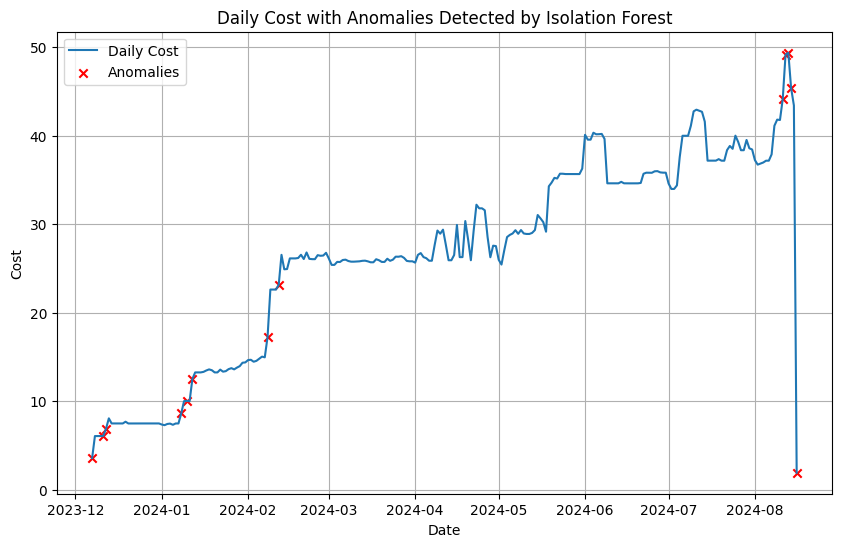

In [121]:
#Fit the isolation model on the whole dataset
# Resample the data to daily frequency, summing the cost for each day
df_daily = df.resample('D').agg({
    'cost': 'sum',  # Sum the cost for each day
    'usage_amount': 'sum',
    'service_type': 'first',  # Optionally, choose the first service type for the day
    'region': 'first',
    'usage_unit': 'first'
}).reset_index()

# Optionally, filter by a specific service type if needed
# df_daily = df_daily[df_daily['service_type'] == 'Compute Engine']

# Prepare the data for Isolation Forest
X = df_daily[['cost']]

# Initialize the Isolation Forest model
model = IsolationForest(contamination=0.05, random_state=42)  # Adjust contamination level as needed

# Fit the model and predict anomalies
df_daily['anomaly'] = model.fit_predict(X)

# Anomalies are labeled as -1, normal points are labeled as 1
anomalies = df_daily[df_daily['anomaly'] == -1]

# Display anomalies
print(anomalies)

# Plotting the anomalies
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(df_daily['usage_end_time'], df_daily['cost'], label='Daily Cost')
plt.scatter(anomalies['usage_end_time'], anomalies['cost'], color='red', label='Anomalies', marker='x')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.title('Daily Cost with Anomalies Detected by Isolation Forest')
plt.legend()
plt.show()


20:22:02 - cmdstanpy - INFO - Chain [1] start processing
20:22:04 - cmdstanpy - INFO - Chain [1] done processing


                      ds         y  usage_amount       service_type  \
0    2023-12-07 09:00:00  0.057339  1.593697e+14     Compute Engine   
126  2023-12-12 15:00:00  0.111177  1.073902e+15     Compute Engine   
288  2023-12-19 09:00:00  0.506972  2.900318e+15           BigQuery   
862  2024-01-12 07:00:00  0.647024  4.460759e+15     Compute Engine   
1495 2024-02-07 16:00:00  0.578682  4.349502e+15     Compute Engine   
...                  ...       ...           ...                ...   
6023 2024-08-14 08:00:00  1.970597  7.391584e+15     Cloud Dataflow   
6024 2024-08-14 09:00:00  2.014386  7.361216e+15     Cloud Dataflow   
6063 2024-08-16 00:00:00  1.434881  6.533794e+15  Artifact Registry   
6064 2024-08-16 01:00:00  0.401656  1.921739e+15          Vertex AI   
6065 2024-08-16 02:00:00  0.092074  1.229606e+13      Cloud Logging   

            region    usage_unit      yhat  yhat_lower  yhat_upper  residual  \
0     europe-west1       seconds  0.275177    0.145031    0.407661 

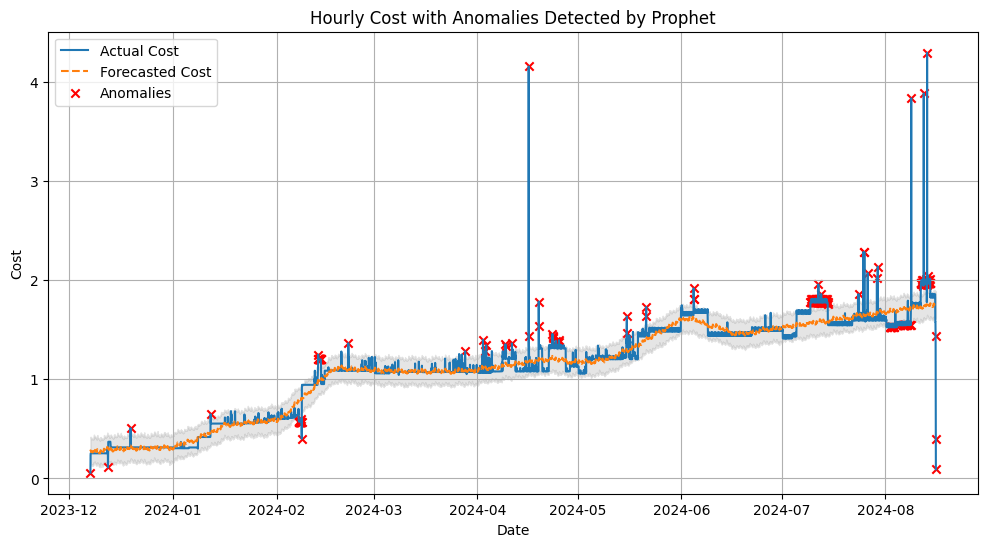

In [119]:
#using prohet:

import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Assuming df_daily is your daily resampled DataFrame
df_daily = df.resample('H').agg({
    'cost': 'sum',
    'usage_amount': 'sum',
    'service_type': 'first',
    'region': 'first',
    'usage_unit': 'first'
}).reset_index()

# Rename columns for Prophet
df_daily.rename(columns={'usage_end_time': 'ds', 'cost': 'y'}, inplace=True)

# Initialize and fit the Prophet model
model = Prophet()
model.fit(df_daily[['ds', 'y']])

# Create a DataFrame to hold future dates for forecasting
future = model.make_future_dataframe(periods=0)  # periods=0 means we only predict on the historical data

# Generate forecasts
forecast = model.predict(future)

# Extract the relevant columns
df_daily['yhat'] = forecast['yhat']
df_daily['yhat_lower'] = forecast['yhat_lower']
df_daily['yhat_upper'] = forecast['yhat_upper']

# Calculate residuals
df_daily['residual'] = df_daily['y'] - df_daily['yhat']

# Set a threshold for anomalies (e.g., residuals beyond the 95th percentile of absolute residuals)
threshold = df_daily['residual'].abs().quantile(0.95)
df_daily['anomaly'] = df_daily['residual'].abs() > threshold

# Display anomalies
anomalies = df_daily[df_daily['anomaly']]
print(anomalies)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(df_daily['ds'], df_daily['y'], label='Actual Cost')
plt.plot(df_daily['ds'], df_daily['yhat'], label='Forecasted Cost', linestyle='--')
plt.fill_between(df_daily['ds'], df_daily['yhat_lower'], df_daily['yhat_upper'], color='gray', alpha=0.2)
plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomalies', marker='x')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.title('Hourly Cost with Anomalies Detected by Prophet')
plt.legend()
plt.show()

18:10:55 - cmdstanpy - INFO - Chain [1] start processing
18:10:55 - cmdstanpy - INFO - Chain [1] done processing


          ds         y  usage_amount    service_type        region  \
0 2023-12-07  3.581648  1.352913e+16  Compute Engine  europe-west1   
1 2023-12-08  6.069814  2.300728e+16  Compute Engine  europe-west1   
2 2023-12-09  6.068106  2.300728e+16  Compute Engine  europe-west1   
3 2023-12-10  6.068404  2.300728e+16  Compute Engine  europe-west1   
4 2023-12-11  6.075154  2.300728e+16  Compute Engine  europe-west1   

     usage_unit  
0       seconds  
1  byte-seconds  
2  byte-seconds  
3  byte-seconds  
4  byte-seconds  
ds              0
y               0
usage_amount    0
service_type    0
region          0
usage_unit      0
dtype: int64


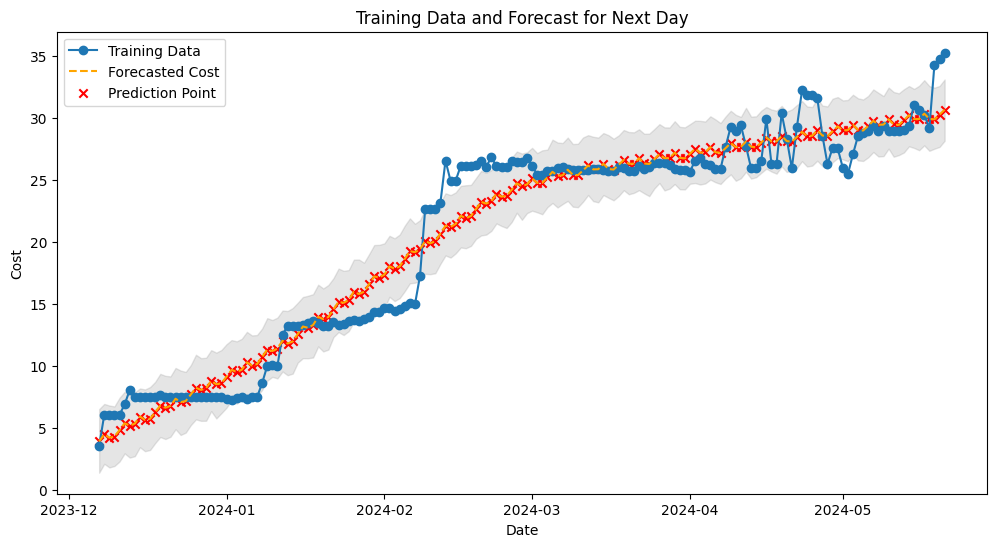

In [98]:
# #forecast window
# import pandas as pd
# from prophet import Prophet
# import matplotlib.pyplot as plt

# # Assuming df_daily is your daily resampled DataFrame
# df_daily = df.resample('D').agg({
#     'cost': 'sum',
#     'usage_amount': 'sum',
#     'service_type': 'first',
#     'region': 'first',
#     'usage_unit': 'first'
# }).reset_index()

# # Rename columns for Prophet
# df_daily.rename(columns={'usage_end_time': 'ds', 'cost': 'y'}, inplace=True)

# # Sort by date to ensure correct order
# df_daily = df_daily.sort_values('ds')

# # Split data into training and testing
# train_data = df_daily.iloc[-5:].reset_index(drop=True)  # Last 5 days for training



# test_data = df_daily.iloc[-6:].reset_index(drop=True)  # Last 6 days (5 for training, 1 for testing)

# # Initialize and fit the Prophet model on training data
# model = Prophet()
# model.fit(train_data[['ds', 'y']])

# # Create a DataFrame to hold future dates for forecasting (including the test date)
# future = test_data[['ds']].copy()  # Use test dates for prediction
# future = model.make_future_dataframe(periods=1, freq='D')  # Add 1 more day for prediction
# forecast = model.predict(future)

# # Merge forecast with test data
# test_data = test_data.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

# # Calculate residuals and identify anomalies
# test_data['residual'] = test_data['y'] - test_data['yhat']
# threshold = test_data['residual'].abs().quantile(0.95)
# test_data['anomaly'] = test_data['residual'].abs() > threshold

# # Display anomalies
# anomalies = test_data[test_data['anomaly']]
# print(anomalies)

# # Plotting the results
# plt.figure(figsize=(12, 6))
# plt.plot(df_daily['ds'], df_daily['y'], label='Actual Cost')
# plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Cost', linestyle='--')
# plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)
# plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomalies', marker='x')
# plt.xlabel('Date')
# plt.ylabel('Cost')
# plt.title('Daily Cost with Anomalies Detected by Prophet')
# plt.legend()
# plt.show()


import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Assuming df_daily is your daily resampled DataFrame
df_daily = df.resample('D').agg({
    'cost': 'sum',
    'usage_amount': 'sum',
    'service_type': 'first',
    'region': 'first',
    'usage_unit': 'first'
}).reset_index()

# Rename columns for Prophet
df_daily.rename(columns={'usage_end_time': 'ds', 'cost': 'y'}, inplace=True)

print(df_daily.head())

# Specify the date range for training
start_date = '2023-03-25'
end_date = '2024-05-20'
train_data = df_daily[(df_daily['ds'] >= start_date) & (df_daily['ds'] <= end_date)].reset_index(drop=True)

# Check for NaN values in the training data
print(train_data.isna().sum())

# Ensure the 'ds' column is in datetime format
train_data['ds'] = pd.to_datetime(train_data['ds'])

# Specify the date for prediction
predict_date = df_daily[df_daily['ds'] > end_date]['ds'].min()
# predict_date = df_daily[df_daily['ds']['2023-12-12']]


# Create a DataFrame for future dates including the prediction date
future = pd.DataFrame({'ds': [predict_date]})
future['ds'] = pd.to_datetime(future['ds'])

# Initialize and fit the Prophet model
model = Prophet()
if len(train_data) >= 2:  # Ensure enough data for fitting
    model.fit(train_data[['ds', 'y']])
    future = model.make_future_dataframe(periods=1, freq='D')  # Add 1 more day for prediction
    forecast = model.predict(future)
    
    # Extract relevant columns for plotting
    train_plot_data = df_daily[(df_daily['ds'] >= start_date) & (df_daily['ds'] <= predict_date)]
    forecast_plot_data = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(future, on='ds', how='right')

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(train_plot_data['ds'], train_plot_data['y'], label='Training Data', marker='o')
    plt.plot(forecast_plot_data['ds'], forecast_plot_data['yhat'], label='Forecasted Cost', linestyle='--', color='orange')
    plt.fill_between(forecast_plot_data['ds'], forecast_plot_data['yhat_lower'], forecast_plot_data['yhat_upper'], color='gray', alpha=0.2)
    plt.scatter(forecast_plot_data['ds'], forecast_plot_data['yhat'], color='red', label='Prediction Point', marker='x')
    plt.xlabel('Date')
    plt.ylabel('Cost')
    plt.title('Training Data and Forecast for Next Day')
    plt.legend()
    plt.show()
else:
    print("Not enough data to fit the model.")


                   ds         y  usage_amount    service_type        region  \
0 2023-12-07 09:00:00  0.057339  1.593697e+14  Compute Engine  europe-west1   
1 2023-12-07 10:00:00  0.233298  9.074721e+14  Compute Engine  europe-west1   
2 2023-12-07 11:00:00  0.253576  9.586371e+14  Compute Engine  europe-west1   
3 2023-12-07 12:00:00  0.253497  9.586388e+14  Compute Engine  europe-west1   
4 2023-12-07 13:00:00  0.253940  9.586368e+14  Compute Engine  europe-west1   

     usage_unit  
0       seconds  
1  byte-seconds  
2         bytes  
3       seconds  
4       seconds  
ds              0
y               0
usage_amount    0
service_type    0
region          0
usage_unit      0
dtype: int64


17:56:03 - cmdstanpy - INFO - Chain [1] start processing
17:56:04 - cmdstanpy - INFO - Chain [1] done processing


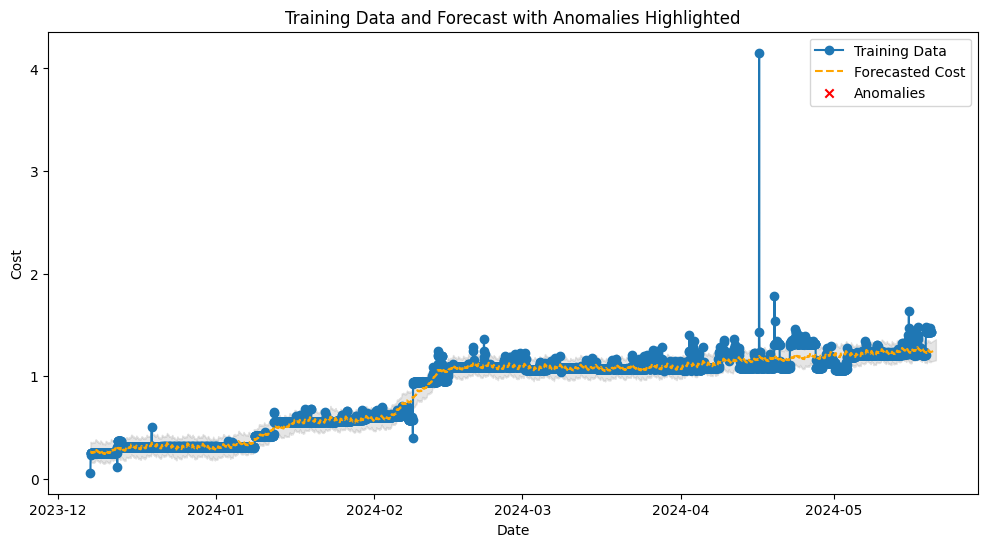

In [89]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Assuming df_daily is your daily resampled DataFrame
df_daily = df.resample('H').agg({
    'cost': 'sum',
    'usage_amount': 'sum',
    'service_type': 'first',
    'region': 'first',
    'usage_unit': 'first'
}).reset_index()

# Rename columns for Prophet
df_daily.rename(columns={'usage_end_time': 'ds', 'cost': 'y'}, inplace=True)

print(df_daily.head())

# Specify the date range for training
start_date = '2023-03-25'
end_date = '2024-05-20'f
train_data = df_daily[(df_daily['ds'] >= start_date) & (df_daily['ds'] <= end_date)].reset_index(drop=True)

# Check for NaN values in the training data
print(train_data.isna().sum())

# Ensure the 'ds' column is in datetime format
train_data['ds'] = pd.to_datetime(train_data['ds'])

# Specify the date for prediction
predict_date = df_daily[df_daily['ds'] > end_date]['ds'].min()

# Create a DataFrame for future dates including the prediction date
future = pd.DataFrame({'ds': [predict_date]})
future['ds'] = pd.to_datetime(future['ds'])

# Initialize and fit the Prophet model
model = Prophet()
if len(train_data) >= 2:  # Ensure enough data for fitting
    model.fit(train_data[['ds', 'y']])
    future = model.make_future_dataframe(periods=1, freq='D')  # Add 1 more day for prediction
    forecast = model.predict(future)
    
    # Extract relevant columns for plotting
    train_plot_data = df_daily[(df_daily['ds'] >= start_date) & (df_daily['ds'] <= predict_date)]
    forecast_plot_data = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(future, on='ds', how='right')

    # Calculate the threshold for anomalies
    threshold = 0.005  # Example: 20% deviation from the forecasted value
    forecast_plot_data['anomaly'] = abs(forecast_plot_data['yhat'] - forecast_plot_data['yhat']) / forecast_plot_data['yhat'] > threshold

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(train_plot_data['ds'], train_plot_data['y'], label='Training Data', marker='o')
    plt.plot(forecast_plot_data['ds'], forecast_plot_data['yhat'], label='Forecasted Cost', linestyle='--', color='orange')
    plt.fill_between(forecast_plot_data['ds'], forecast_plot_data['yhat_lower'], forecast_plot_data['yhat_upper'], color='gray', alpha=0.2)
    plt.scatter(forecast_plot_data[forecast_plot_data['anomaly']]['ds'], 
                forecast_plot_data[forecast_plot_data['anomaly']]['yhat'],
                color='red', 
                label='Anomalies', 
                marker='x')
    plt.xlabel('Date')
    plt.ylabel('Cost')
    plt.title('Training Data and Forecast with Anomalies Highlighted')
    plt.legend()
    plt.show()
else:
    print("Not enough data to fit the model.")


20:11:05 - cmdstanpy - INFO - Chain [1] start processing
20:11:05 - cmdstanpy - INFO - Chain [1] done processing


          ds          y  usage_amount    service_type        region  \
0 2024-02-13  26.553516  1.427796e+17  Compute Engine  europe-west1   

  usage_unit       yhat  yhat_lower  yhat_upper  anomaly  
0      bytes  18.772384   16.334872   21.246501     True  


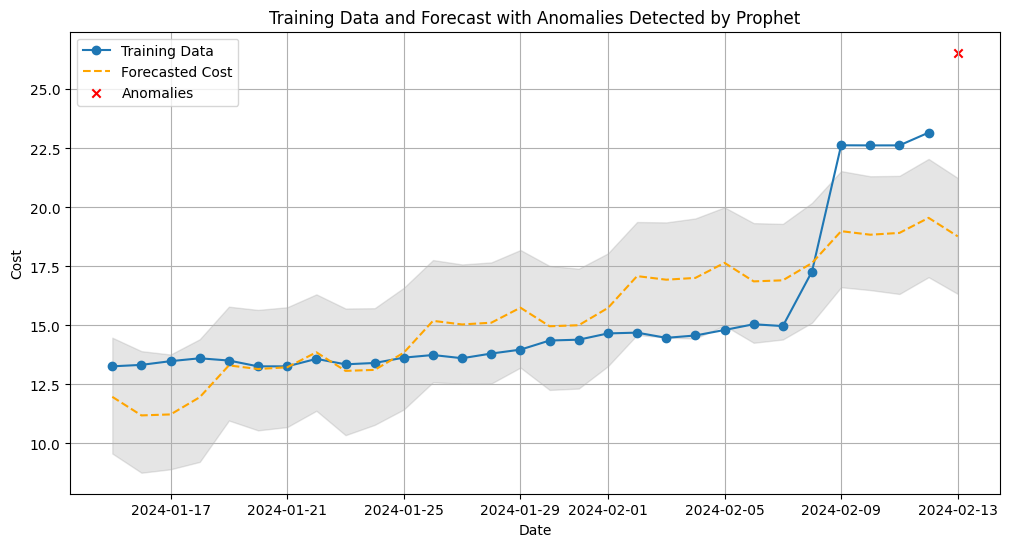

In [117]:
# import pandas as pd
# from prophet import Prophet
# import matplotlib.pyplot as plt

# # Assuming df_daily is your daily resampled DataFrame
# df_daily = df.resample('D').agg({
#     'cost': 'sum',
#     'usage_amount': 'sum',
#     'service_type': 'first',
#     'region': 'first',
#     'usage_unit': 'first'
# }).reset_index()

# # Rename columns for Prophet
# df_daily.rename(columns={'usage_end_time': 'ds', 'cost': 'y'}, inplace=True)

# # Sort by date to ensure correct order
# df_daily = df_daily.sort_values('ds')

# # Specify date range for training and testing
# train_start_date = '2023-04-01'
# train_end_date = '2024-05-29'
# test_start_date = '2024-05-30'
# test_end_date = '2023-05-30'

# # start_date = '2023-03-25'
# # end_date = '2024-05-20'
# # Split data into training and testing
# train_data = df_daily[(df_daily['ds'] >= train_start_date) & (df_daily['ds'] <= train_end_date)].reset_index(drop=True)
# test_data = df_daily[(df_daily['ds'] >= test_start_date) & (df_daily['ds'] <= test_end_date)].reset_index(drop=True)

# # Initialize and fit the Prophet model on training data
# model = Prophet()
# model.fit(train_data[['ds', 'y']])

# # Create a DataFrame to hold future dates for forecasting (including the test date)
# future = model.make_future_dataframe(periods=len(test_data), freq='D')  # Adjust periods to match the test data length
# forecast = model.predict(future)

# # Merge forecast with test data
# test_data = test_data.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

# # Calculate residuals and identify anomalies
# test_data['residual'] = test_data['y'] - test_data['yhat']
# threshold = test_data['residual'].abs().quantile(0.95)
# test_data['anomaly'] = test_data['residual'].abs() > threshold

# # Display anomalies
# anomalies = test_data[test_data['anomaly']]
# print(anomalies)

# # Plotting the results
# plt.figure(figsize=(12, 6))

# # Plot training data
# plt.plot(train_data['ds'], train_data['y'], label='Training Data', marker='o')

# # Plot forecasted data
# plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Cost', linestyle='--', color='orange')

# # Plot the forecast uncertainty intervals
# plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)

# # Plot anomalies
# plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomalies', marker='x')

# plt.xlabel('Date')
# plt.ylabel('Cost')
# plt.title('Training Data and Forecast with Anomalies Detected by Prophet')
# plt.legend()
# plt.show()

import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Assuming df_daily is your daily resampled DataFrame
df_daily = df.resample('D').agg({
    'cost': 'sum',
    'usage_amount': 'sum',
    'service_type': 'first',
    'region': 'first',
    'usage_unit': 'first'
}).reset_index()

# Rename columns for Prophet
df_daily.rename(columns={'usage_end_time': 'ds', 'cost': 'y'}, inplace=True)

# Sort by date to ensure correct order
df_daily = df_daily.sort_values('ds')

# Specify date range for training and testing
train_start_date = '2024-01-15'
train_end_date = '2024-02-12'
test_start_date = '2024-02-13'
test_end_date = '2024-02-13'


# Split data into training and testing
train_data = df_daily[(df_daily['ds'] >= train_start_date) & (df_daily['ds'] <= train_end_date)].reset_index(drop=True)
test_data = df_daily[(df_daily['ds'] >= test_start_date) & (df_daily['ds'] <= test_end_date)].reset_index(drop=True)

# Initialize and fit the Prophet model on training data
model = Prophet()
model.fit(train_data[['ds', 'y']])

# Create a DataFrame to hold future dates for forecasting (including the test date)
future = model.make_future_dataframe(periods=len(test_data), freq='D')  # Adjust periods to match the test data length
forecast = model.predict(future)

# Merge forecast with test data
test_data = test_data.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

# Identify anomalies as points outside the forecast uncertainty intervals
test_data['anomaly'] = (test_data['y'] < test_data['yhat_lower']) | (test_data['y'] > test_data['yhat_upper'])

# Display anomalies
anomalies = test_data[test_data['anomaly']]
print(anomalies)

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(train_data['ds'], train_data['y'], label='Training Data', marker='o')

# Plot forecasted data
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Cost', linestyle='--', color='orange')

# Plot the forecast uncertainty intervals
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)

# Plot anomalies
plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomalies', marker='x')

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Cost')
plt.title('Training Data and Forecast with Anomalies Detected by Prophet')
plt.legend()
plt.show()

